<h1 align="center"> Homework assignment #9: Residual Neural </h1>
<h2 align="center"> Assigned Nov. 3 and Due Nov. 15 </h2>
<h3 align="center"> MSSE 277B: Machine Learning Algorithms </h3>

**1. Residual Neural Networks applied to classification. (20 pt)**  We will
again use the MNIST data set to train, validation, and test but this time
using a ResNN. As described in lecture, we are going to formulate a skip
connection in order to improve gradient flow.
Using the CNN developed in HW#8, adapt your architecture to the one
shown in the figure below (architecture with two layers each composed
of one convolution and one pooling layer.) Use ReLU as your activation
function. Use conv/pooling layers that with kernel, stride and padding
size that lead to output size of 12x5x5 before flattening. Flatten the
resulting feature maps and use two fully connected (FC) layers of output
size (300,10). Add an additive skip connection from flattened layer to the
second fully connected layer. Again, use the ADAM optimizer with
learning rate of 1e-3, batchsize of 128, and 30 epochs (you can also train for longer if time permits). Split
the MNIST training set into 2/3 for training and 1/3 for validation, you don’t need to do KFold this time.
Use batch normalization of data, choose some regularization techniques and converge your training to
where the loss function is minimal.

In [1]:
#Import the MIST data 
import pickle
(train_X, train_y), (test_X, test_y) = pickle.load(open("mnist.pkl", "rb"))
# Normalize the data 
import numpy as np
# Each image is divided by its own maximum pixel value for x values 
train_X = train_X / np.max(train_X)
test_X = test_X/ np.max(test_X)

**(a) (10 pt)** Run the model with and without batch normalization. Which give you better test accuracy?

In [2]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [3]:
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
import torch


def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
        elif optimizer_type == "adam_12":
            self.optimizer = Adam(model.parameters(), learning_rate, weight_decay=1e-5)
            
            
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float))
        outputs = torch.tensor(outputs, dtype=torch.int64)
        val_inputs = self.input_transform(torch.tensor(val_inputs, dtype=torch.float))
        val_outputs = torch.tensor(val_outputs, dtype=torch.int64)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_lambda = 1e-5
                    l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())

                    loss = loss + l2_lambda * l2_norm

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.detach().cpu().item() * batch_importance
                acc = torch.sum(torch.argmax(batch_predictions, axis = -1) == batch_output) / len(batch_predictions)
                epoch_acc += acc.detach().cpu().item() * batch_importance 
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        if torch.is_tensor(inputs):
            inputs = self.input_transform(inputs) 
        
        else:
            inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float))
            outputs = torch.tensor(outputs, dtype=torch.int64)
        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs) 
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
               batch_predictions = self.model(batch_input)
               loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
            batch_acc = torch.sum(torch.argmax(batch_predictions, axis=-1) ==batch_output) / len(batch_predictions)
            losses += loss.detach().cpu().item() * batch_importance 
            acc += batch_acc.detach().cpu().item() * batch_importance
            
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [15]:
from sklearn.model_selection import train_test_split,KFold 


def Kfold(model_func,k,Xs,ys,test_Xs,test_ys,epochs,draw_curve=True,early_stop=False,batchsize=128 ,optimizer='adam',lr=1e-3,l2=False,
input_shape=(-1,1024)):
    """
    Do Kfold cross validation with the specified arguments 
    model_func: function.
        Constructor of the model.
    k: int. The number of fold
    Xs: np.array, The shape of Xs.reshape(input_shape) should be(ndata,nfeatures)
    ys: np.array shape (ndata,)
    test_Xs: np.array, The shape of test_Xs.reshape(input_shape) should be(ndata,nfeatures)
    test_ys: np.array shape (ndata,)
    epoch: int
    batch_size: int
    early_stop: bool
    lr: float. learning_rate
    l2: bool
    optimizer: 'adam' or 'sgd'
    input_shape: tuple
    """
# The total number of examples for training the network 
    total_num=len(Xs)
# Built in K-fold function in Sci-Kit Learn 
    kf= KFold(n_splits=k,shuffle=True)
    train_acc_all=[]
    test_acc_all=[]
    fold=0
    for train_selector,val_selector in kf.split(range(total_num)):
        fold+=1
        print(f'Fold #{fold}')
        train_Xs=Xs[train_selector]
        val_Xs=Xs[val_selector]
        train_ys=ys[train_selector]
        val_ys=ys[val_selector]
        model=model_func() 
        if fold ==1:
            print(f"{model_func.__name__} parameters:", sum([len(item.flatten()) for item in model.parameters()]))
    trainer = Trainer(model, optimizer, lr, epochs, batchsize, lambda x: x.reshape(input_shape))
    
    log=trainer.train(train_Xs,train_ys,val_Xs,val_ys,early_stop=early_stop,l2=l2)
    if draw_curve: 
        plt.figure()
        plt.plot(log["losses"], label="losses") 
        plt.plot(log["val_losses"], label="validation_losses") 
        plt.legend()
        plt.title(f'Fold #{fold} loss')

        plt.figure()
        plt.plot(log["accuracies"], label="accuracies") 
        plt.plot(log["val_accuracies"], label="validation_accuracies")
        plt.legend()
        plt.title(f'Fold #{fold} accuracy')
       # Report result for this fold
    if early_stop:
        report_idx= np.argmin(log["val_losses"])
    else: 
        report_idx=-1
    test_acc=trainer.evaluate(test_Xs,test_ys,print_acc=False)[1]
    train_acc_all.append(log["accuracies"][report_idx])
    test_acc_all.append(test_acc)
    print("Train accuracy:",log["accuracies"][report_idx]) 
    print("Validation accuracy:",log["val_accuracies"][report_idx]) 
    print("Test accuracy:",test_acc)
    print("Final results:")
    print("Training accuracy:%f+-%f"%(np.average(train_acc_all),np.std(train_acc_all)))
    print("Testing accuracy:%f+-%f"%(np.average(test_acc_all),np.std(test_acc_all)))

In [6]:
import torch
import torch.nn as nn
class CNN_Bach_norm(nn.Module):
    def __init__(self):
        super(CNN_Bach_norm, self).__init__()
        # Convolution layers
        self.conv = nn.ModuleList([
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),  # Output: (B, 6, 28, 28)
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),  # Output: (B, 16, 24, 24)
        ])
        # Pooling layer
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Reduces size to (B, 16, 12, 12) then (B, 16, 6, 6)
        # Fully connected layers
        self.fc = nn.ModuleList([
            nn.Linear(16 * 5 * 5, 300),  
            nn.Linear(300, 10)
        ])
        # Activation function
        self.activation = nn.ReLU()
        # Batch normalization layers
        self.bn = nn.ModuleList([nn.BatchNorm2d(6), nn.BatchNorm2d(16)])

    def forward(self, x):
        x = x.view(-1, 1, 32, 32)  # Assuming input size is 32x32
        for i in range(2):
            x = self.pooling(self.activation(self.bn[i](self.conv[i](x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layers
        x = self.activation(self.fc[0](x))
        x = self.fc[1](x)  # Remove softmax from here, it should be applied during loss calculation
        return x


Fold #1
CNN_Bach_norm parameters: 125926
Fold #2
Fold #3


  3%|██▌                                                                           | 1/30 [00:08<04:18,  8.93s/it]

Epoch 1/30 - Loss: 0.220 - Acc: 0.938
              Val_loss: 0.084 - Val_acc: 0.974


 37%|████████████████████████████▏                                                | 11/30 [01:38<02:49,  8.94s/it]

Epoch 11/30 - Loss: 0.010 - Acc: 0.997
              Val_loss: 0.057 - Val_acc: 0.986


 70%|█████████████████████████████████████████████████████▉                       | 21/30 [03:08<01:21,  9.02s/it]

Epoch 21/30 - Loss: 0.007 - Acc: 0.997
              Val_loss: 0.053 - Val_acc: 0.989


func:'train'  took: 268.5913 sec
Train accuracy: 0.9999999999999958
Validation accuracy: 0.9922499999999979
Test accuracy: 0.9923000000000012
Final results:
Training accuracy:1.000000+-0.000000
Testing accuracy:0.992300+-0.000000


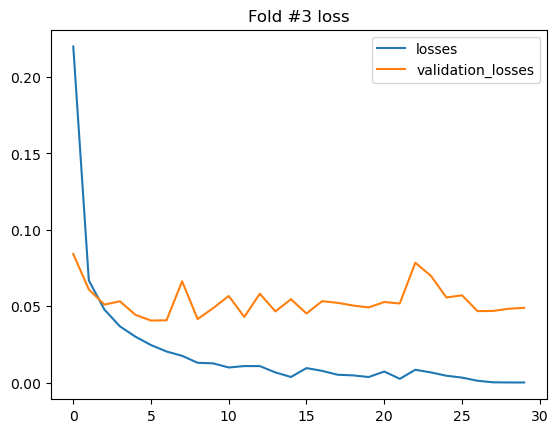

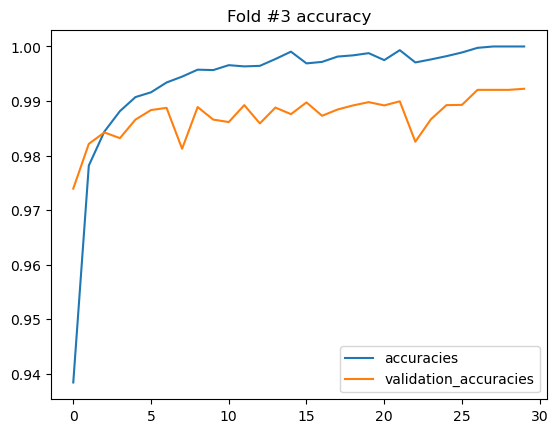

In [7]:
# With Batch normalization
Kfold(CNN_Bach_norm, 3, train_X, train_y,test_X,test_y,30,optimizer='adam')

In [8]:


class CNN_WOBach_norm(nn.Module):
    def __init__(self):
        super(CNN_WOBach_norm, self).__init__()
        # Convolution layers 
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)  # Output: (B, 6, 28, 28)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5, stride=1, padding=0) # Output: (B, 12, 24, 24)

        # Pooling layer
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # Reduces size first to (B, 6, 14, 14), then to (B, 12, 12, 12)

        # Fully connected layers
        self.fc1 = nn.Linear(12 * 5 * 5, 300)  
        self.fc2 = nn.Linear(300, 10)

        # Activation function
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pooling(x)
        
        x = self.conv2(x)
        x = self.activation(x)
        x = self.pooling(x)

        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x) 
        return x


Fold #1
CNN_WOBach_norm parameters: 95278
Fold #2
Fold #3


  3%|██▌                                                                           | 1/30 [00:08<04:09,  8.60s/it]

Epoch 1/30 - Loss: 0.389 - Acc: 0.888
              Val_loss: 0.136 - Val_acc: 0.960


 37%|████████████████████████████▏                                                | 11/30 [01:34<02:43,  8.59s/it]

Epoch 11/30 - Loss: 0.017 - Acc: 0.994
              Val_loss: 0.051 - Val_acc: 0.985


 70%|█████████████████████████████████████████████████████▉                       | 21/30 [03:00<01:17,  8.60s/it]

Epoch 21/30 - Loss: 0.006 - Acc: 0.998
              Val_loss: 0.062 - Val_acc: 0.987


func:'train'  took: 258.0590 sec
Train accuracy: 0.9993499999999971
Validation accuracy: 0.989049999999998
Test accuracy: 0.990500000000001
Final results:
Training accuracy:0.999350+-0.000000
Testing accuracy:0.990500+-0.000000


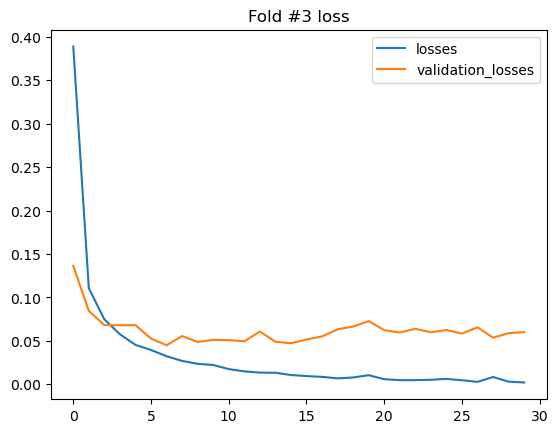

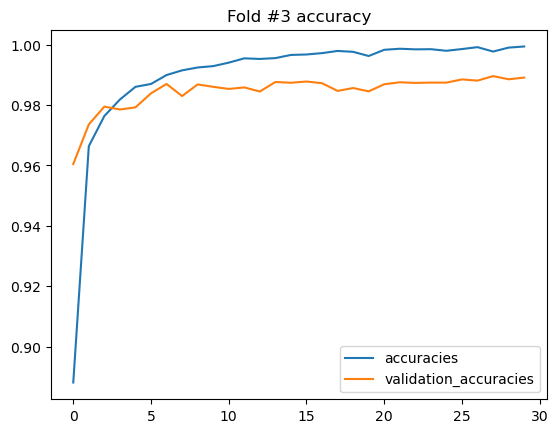

In [9]:
# Without Batch normalization
Kfold(CNN_WOBach_norm, 3, train_X, train_y,test_X,test_y,30,optimizer='adam')

#### Answer 1a:

The model with batch normalization performs slightly better on the test set compared to the one without batch normalization, showing a test accuracy of 0.9923 versus 0.9905. Batch normalization has proven helpful in stabilizing and speeding up the training process. In this instance, it also seems to positively impact the model's generalization capabilities, as reflected by the higher test accuracy. However, it's crucial to consider other factors, such as the complexity of the model, training time, and potential overfitting issues. For example, if implementing batch normalization significantly increases the model's complexity or training duration, the minor improvement in accuracy might not justify the extra resources. Moreover, the extremely high training accuracy, almost hitting 1.0 in both cases, raises concerns about the model overfitting.


**(b) (10 pt)** Run the model with and without the skip connection at learning rate of 5e-3 for 10 epochs.
Do you see faster training and/or better test accuracy with the skip connection?

In [20]:
class CNN_Skip(nn.Module):
    def __init__(self):
        super(CNN_Skip, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)  # Output: (B, 6, 28, 28)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5, stride=1, padding=0)  # Output: (B, 12, 24, 24)
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: (B, 12, 12, 12)

        # Flatten and Fully Connected layers
        self.fc1 = nn.Linear(12 * 5 * 5, 12 * 5 * 5)  # Adjusted to match the size of flattened
        self.fc2 = nn.Linear(12 * 5 * 5, 10)  # Adjusted accordingly
        self.activation = nn.ReLU()

    def forward(self, x):
        # Convolution 1
        x = x.view(-1, 1, 32, 32)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.pool(x)

        # Convolution 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.pool(x)  # Output: (B, 12, 5, 5)

        # Flatten
        flattened = x.view(-1, 12 * 5 * 5)

        # Fully Connected Layers with Skip Connection
        x = self.fc1(flattened)
        x = self.activation(x)

        # Additive Skip Connection
        skip_connection = x + flattened
        y = self.fc2(skip_connection)

        return y


Fold #1
CNN_Skip parameters: 95314
Fold #2
Fold #3


 10%|███████▊                                                                      | 1/10 [00:09<01:25,  9.51s/it]

Epoch 1/10 - Loss: 0.195 - Acc: 0.941
              Val_loss: 0.107 - Val_acc: 0.967


func:'train'  took: 95.2270 sec
Train accuracy: 0.9937999999999991
Validation accuracy: 0.988999999999998
Test accuracy: 0.989600000000001
Final results:
Training accuracy:0.993800+-0.000000
Testing accuracy:0.989600+-0.000000


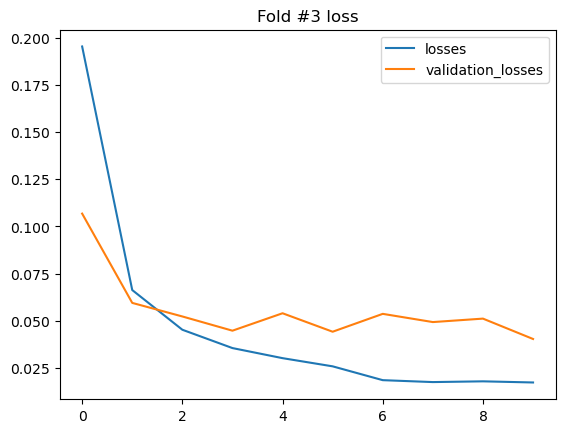

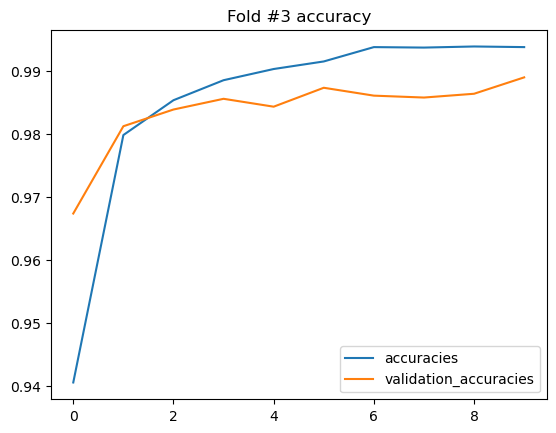

In [21]:
# With skip connection normalization

Kfold(CNN_Skip,3,train_X,train_y,test_X,test_y,10,draw_curve=True,early_stop=False,batchsize=128 ,optimizer='adam',lr=5e-3,l2=False)

Fold #1
CNN_Bach_norm parameters: 125926
Fold #2
Fold #3


 10%|███████▊                                                                      | 1/10 [00:09<01:26,  9.66s/it]

Epoch 1/10 - Loss: 0.165 - Acc: 0.949
              Val_loss: 0.061 - Val_acc: 0.980


func:'train'  took: 96.4841 sec
Train accuracy: 0.9955999999999992
Validation accuracy: 0.9875499999999979
Test accuracy: 0.9879000000000008
Final results:
Training accuracy:0.995600+-0.000000
Testing accuracy:0.987900+-0.000000


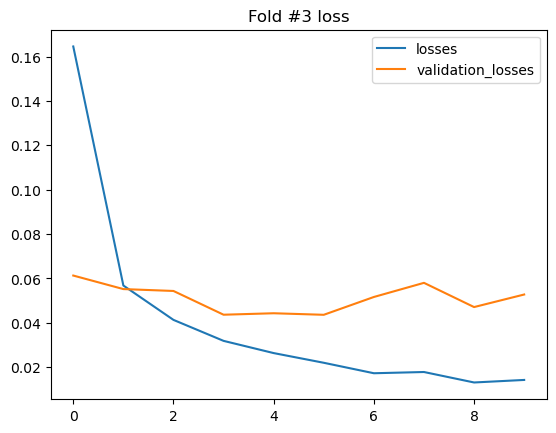

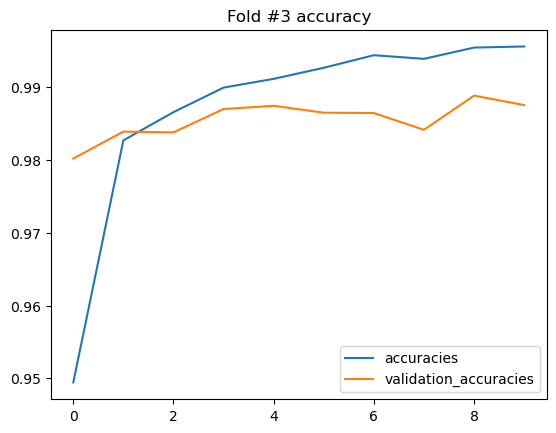

In [22]:
# Without skip connection normalization

Kfold(CNN_Bach_norm,3,train_X,train_y,test_X,test_y,10,draw_curve=True,early_stop=False,batchsize=128 ,optimizer='adam',lr=5e-3,l2=False)

#### Answer for 1b:

Implementing skip connections in the model seems to offer a dual advantage: a slight reduction in training time by taking 95.22 seconds with the skip connection and 96.481 without. Along with an improvement in test accuracy. Skip connections are beneficial in mitigating the vanishing gradient problem and enabling deeper networks to learn more effectively, which likely contributes to these observed benefits. However, the differences are relatively minor. Since the test accuracy with a skip connection is 0.9938 and without its 0.9879. 